# WindEye

Use computer vision to identify and analyze wind turbines in satellite imagery.
Part of the GBDX 2018 entry by the World Resources Institute (WRI) and Duke University.
1. Import manually assembled lat/long coordinates for sites with and without wind turbines around the globe.
2. Order imagery clips from WorldView 2 for these locations, grayscale, and resize to standard shape (64x64 pixels).
3. Extract HOG features from images.
4. Train a binary classifier on these HOG features.
5. Deploy the classifier in a new geography to find wind turbines.
6. Deploy the classifier in historical imagery at turbine locations to identify construction date.
7. Train a convolutional neural network (CNN) on images.
8. Repeat steps above with CNN.


In [99]:
# import what we need

import numpy as np
import matplotlib.pyplot as plt
import pickle
import requests
import csv
from random import shuffle
from itertools import chain
from skimage import color, feature, transform
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from shapely.geometry import box
from gbdxtools import CatalogImage, Interface
gbdx = Interface()

%matplotlib inline

WIND_TURBINE_COORDINATES = 'wind_turbine_coordinates_all.csv'
NOT_WIND_TURBINE_COORDINATES = 'not_wind_turbine_coordinates_all.csv'
WIND_TURBINE_PICKLE = 'wind_turbine_images.p'
NOT_WIND_TURBINE_PICKLE = 'not_wind_turbine_images.p'
IM_SIZE = 64   # pixels per side for analyzed images

BATCH_SIZE = 64
VALID_FRACTION = 0.2

In [ ]:
# upgrade pip and install sklearn

!pip install --upgrade pip
!pip install sklearn
!pip install hpy5

In [78]:
# download coordinates files
url1 = "https://github.com/colinmccormick/WindEye/raw/master/wind_turbine_coordinates_all.csv"
url2 = "https://github.com/colinmccormick/WindEye/raw/master/not_wind_turbine_coordinates_all.csv"
r1 = requests.get(url1,allow_redirects=True)
r2 = requests.get(url2,allow_redirects=True)
open(WIND_TURBINE_COORDINATES,'w').write(r1.content)
open(NOT_WIND_TURBINE_COORDINATES,'w').write(r2.content)
!ls

Active_Fire_Detection_using_SWIR_Imagery.ipynb
Advanced_Band_Math_Tutorial_Using_SWIR_Imagery_for_Creating_Spectral_Indices.ipynb
Advanced_Imagery_Access.ipynb
Algorithm_Prototyping_Coastline_Extraction.ipynb
Beginner_Band_Math_for_Remote_Sensing_Spectral_Indices.ipynb
Detecting_Change_Over_Time.ipynb
Detecting_Tents_in_the_Dabaab_Kenya_Refugee_Camp.ipynb
Image_Classification_Part_1_Building_a_Simple_Image_Classifier.ipynb
Imagery_and_AOIs.ipynb
Imagery_test_01.ipynb
Imagery_test_02.ipynb
Introduction_to_GBDX_notebooks.ipynb
Ordering_and_Working_with_Imagery.ipynb
WindEye_v01.ipynb
not_wind_turbine_coordinates_all.csv
not_wind_turbine_images.p
output.bak
output.dat
output.dir
ports.json
wind_turbine_coordinates_all.csv
wind_turbine_images.p


In [79]:
# define utility functions

def make_bbox(coords,box_side_meters=150):
    # define a bbox of specified side length centered on coords
    # should probably upgrade this with haversine function
    latitude,longitude = coords
    assert latitude >=-90 and latitude <= 90, u"Error with latitude"
    assert longitude >=-180 and longitude <= 180, u"Error with longitude"
    earth_circumference_meters = 40000000
    d_lat = 0.5 * 360 * box_side_meters / earth_circumference_meters
    #d_long = d_lat / np.cos(2 * np.pi * latitude / 360) 
    d_long = d_lat
    return [longitude-d_long,latitude-d_lat,longitude+d_long,latitude+d_lat]
    
def search_unordered(bbox, _type=None, count=100, cloud_cover=10):
    # search for available imagery in bbox
    aoi = box(*bbox).wkt
    if _type:
        query = "item_type:{} AND item_type:DigitalGlobeAcquisition".format(_type)
    else:
        query = "item_type:DigitalGlobeAcquisition"
    query += " AND attributes.cloudCover_int:<{}".format(cloud_cover)
    return gbdx.vectors.query(aoi, query, count=count)

def order(img_id):
    # order imagery
    order = gbdx.Task("Auto_Ordering", cat_id=img_id)
    order.impersonation_allowed = True
    wf = gbdx.Workflow([order])
    wf.execute()
    return wf

In [103]:
# read turbine and non-turbine coordinates
# order: latitude,longitude

turbine_coordinates = []
with open(WIND_TURBINE_COORDINATES,'r') as f:
    datareader = csv.reader(f)
    header = next(datareader)
    for row in datareader:
        latitude = float(row[0])
        longitude = float(row[1])
        country = row[2]    
        turbine_coordinates.append({'latitude':latitude,'longitude':longitude,'country':country})
print(u"Read {0} wind turbine locations.".format(len(turbine_coordinates)))
        
not_turbine_coordinates = []
with open(NOT_WIND_TURBINE_COORDINATES,'r') as f:
    datareader = csv.reader(f)
    header = next(datareader)
    for row in datareader:
        latitude = float(row[0])
        longitude = float(row[1])
        country = row[2]    
        not_turbine_coordinates.append({'latitude':latitude,'longitude':longitude,'country':country})
print(u"Read {0} not wind turbine locations.".format(len(not_turbine_coordinates)))
  
# combine location lists and randomize
#all_locations = zip(np.ones(len(turbine_locations)),turbine_locations) \
#                + zip(np.zeros(len(not_turbine_locations)),not_turbine_locations) 
#shuffle(all_locations)


Read 1197 wind turbine locations.
Read 1129 not wind turbine locations.


In [35]:
# set up tracking of images ordered
wfs = []
catalog_ids = []

In [104]:
# search for imagery at known turbine and not-turbine locations
# limit search to specific sensor platform for consistency
# order most chronologically recent image

N_IMAGES = 1028

#sensor_plaform = u"SENTINEL2"
#sensor_platform = u"WV03"
sensor_platform = u"WV02"

# turbine locations
turbine_locations = []
for n in range(N_IMAGES):
    location = turbine_coordinates[n]
    latitude = location['latitude']
    longitude = location['longitude']
    bbox = make_bbox((latitude,longitude))
    records = search_unordered(bbox,_type=sensor_platform)
    try:
        r = records[0]   # assumes most recent image first - should confirm
    except:
        print(u"No images for coordinates: {0},{1}; skipping.".format(latitude,longitude))
        continue
    cat_id = r['properties']['attributes']['catalogID']
    date = r['properties']['item_date']
    sensor = r['properties']['attributes']['sensorPlatformName']
    print(u"{0},{1}: {2} ({3}) is from {4}.".format(latitude,longitude,cat_id,sensor,date))
    turbine_locations.append({'bbox':bbox,'catalog_id':cat_id,'date':date,'sensor':sensor})  
    if cat_id not in catalog_ids:
        catalog_ids.append(cat_id)
        print(u"Ordering catalog ID {0}".format(cat_id))
        wfs.append(order(cat_id))
        
# not turbine locations
not_turbine_locations = []
for n in range(N_IMAGES):
    location = not_turbine_coordinates[n]
    latitude = location['latitude']
    longitude = location['longitude']
    bbox = make_bbox((latitude,longitude))
    records = search_unordered(bbox,_type=sensor_platform)
    try:
        r = records[0]   # assumes most recent image first - should confirm
    except:
        print(u"No images for coordinates: {0},{1}; skipping.".format(latitude,longitude))
        continue
    cat_id = r['properties']['attributes']['catalogID']
    date = r['properties']['item_date']
    sensor = r['properties']['attributes']['sensorPlatformName']
    print(u"{0},{1}: {2} ({3}) is from {4}.".format(latitude,longitude,cat_id,sensor,date))
    not_turbine_locations.append({'bbox':bbox,'catalog_id':cat_id,'date':date,'sensor':sensor})  
    if cat_id not in catalog_ids:
        catalog_ids.append(cat_id)
        print(u"Ordering catalog ID {0}".format(cat_id))
        wfs.append(order(cat_id))

print(u"Ordered {0} images.".format(len(wfs)))


-37.986118,142.185182: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.985767,142.193529: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.988139,142.190391: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.990794,142.188363: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.990202,142.182376: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.991876,142.192944: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.994928,142.191786: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.994903,142.186013: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.996273,142.182205: 10300100797F4500 (WORLDVIEW02) is from 2018-03-22T00:53:03.000Z.
-37.998513,142.190509: 103001004D517000 (WORLDVIEW02) is from 2015-11-16T00:45:18.213Z.
-37.997938,142.194747: 103001004D517000 (WORLDVIEW02) is from 2015-11-16T00:45:18.213Z.
-37.999375,142.186131: 103001004

-31.598998,118.486894: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
-31.601803,118.487828: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
-31.60428,118.492205: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
-31.609351,118.491518: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
-31.612997,118.493074: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
-31.616934,118.493932: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
-31.620762,118.499168: 1030010061084A00 (WORLDVIEW02) is from 2016-12-02T02:32:00.060Z.
48.104924,16.890342: 103001006DCA8C00 (WORLDVIEW02) is from 2017-07-29T10:08:28.000Z.
48.102746,16.88736: 103001006DCA8C00 (WORLDVIEW02) is from 2017-07-29T10:08:28.000Z.
48.100883,16.893711: 103001006DCA8C00 (WORLDVIEW02) is from 2017-07-29T10:08:28.000Z.
48.100811,16.883605: 103001006DCA8C00 (WORLDVIEW02) is from 2017-07-29T10:08:28.000Z.
48.098432,16.889699: 103001006DCA8C00 (WOR

-31.288091,-71.622909: 103001004E4BF100 (WORLDVIEW02) is from 2016-01-13T15:07:18.747Z.
-31.287495,-71.62086: 103001004E4BF100 (WORLDVIEW02) is from 2016-01-13T15:07:18.747Z.
-31.286702,-71.618907: 103001004E4BF100 (WORLDVIEW02) is from 2016-01-13T15:07:18.747Z.
-37.7412,-73.575493: 1030010050824F00 (WORLDVIEW02) is from 2016-02-15T14:51:18.716Z.
-37.742744,-73.573417: 1030010050824F00 (WORLDVIEW02) is from 2016-02-15T14:51:18.716Z.
-37.744403,-73.570853: 1030010050824F00 (WORLDVIEW02) is from 2016-02-15T14:51:18.716Z.
-37.746142,-73.56853: 1030010050824F00 (WORLDVIEW02) is from 2016-02-15T14:51:18.716Z.
-37.749306,-73.564968: 1030010050824F00 (WORLDVIEW02) is from 2016-02-15T14:51:18.716Z.
-31.313125,-71.622311: 103001004E4BF100 (WORLDVIEW02) is from 2016-01-13T15:07:18.747Z.
-31.313141,-71.621029: 103001004E4BF100 (WORLDVIEW02) is from 2016-01-13T15:07:18.747Z.
-31.313177,-71.619715: 103001004E4BF100 (WORLDVIEW02) is from 2016-01-13T15:07:18.747Z.
-31.305963,-71.630988: 103001004E4BF

59.376108,24.080057: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.37402,24.084263: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.371845,24.080164: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.369637,24.075787: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.369013,24.085422: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.36687,24.081173: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.366182,24.090893: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.364049,24.086666: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.364148,24.094906: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.36218,24.099262: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
59.36066,24.093318: 1030010063A5BB00 (WORLDVIEW02) is from 2017-02-08T10:17:11.579Z.
58.449484,23.734546: 1030050071F96B00 (WORLDVIEW02) is fro

13.408103,39.577577: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.409726,39.57807: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.411239,39.578843: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.412758,39.579594: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.414438,39.579856: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.416139,39.579872: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.417824,39.579991: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.419426,39.579384: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.420893,39.580248: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.422484,39.579674: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.424175,39.579073: 103001006A373800 (WORLDVIEW02) is from 2017-07-11T08:00:32.000Z.
13.426768,39.579298: 103001006A373800 (WORLDVIEW02) is 

41.329945,14.972402: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.330436,14.969666: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.329429,14.967359: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.329332,14.965407: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.326392,14.966415: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.327085,14.964087: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.326327,14.962746: 10300100682FE500 (WORLDVIEW02) is from 2017-04-09T10:08:20.490Z.
41.326335,14.956931: 103001004F15B800 (WORLDVIEW02) is from 2016-01-07T10:07:40.188Z.
41.326214,14.953337: 103001004F15B800 (WORLDVIEW02) is from 2016-01-07T10:07:40.188Z.
41.326827,14.950762: 103001004F15B800 (WORLDVIEW02) is from 2016-01-07T10:07:40.188Z.
41.325796,14.95059: 103001004F15B800 (WORLDVIEW02) is from 2016-01-07T10:07:40.188Z.
41.324676,14.950569: 103001004F15B800 (WORLDVIEW02) is 

32.499709,-116.091129: 1030010077096C00 (WORLDVIEW02) is from 2018-01-11T18:27:26.000Z.
32.498157,-116.090024: 1030010077096C00 (WORLDVIEW02) is from 2018-01-11T18:27:26.000Z.
32.496474,-116.089359: 1030010077096C00 (WORLDVIEW02) is from 2018-01-11T18:27:26.000Z.
32.494601,-116.089268: 1030010077096C00 (WORLDVIEW02) is from 2018-01-11T18:27:26.000Z.
32.493194,-116.088007: 1030010077096C00 (WORLDVIEW02) is from 2018-01-11T18:27:26.000Z.
35.623215,-5.438439: 1030010067548C00 (WORLDVIEW02) is from 2017-04-12T11:38:47.345Z.
35.620849,-5.441805: 1030010067548C00 (WORLDVIEW02) is from 2017-04-12T11:38:47.345Z.
35.620727,-5.438125: 103001007543D200 (WORLDVIEW02) is from 2017-11-07T11:34:06.000Z.
35.620692,-5.431291: 1030010067548C00 (WORLDVIEW02) is from 2017-04-12T11:38:47.345Z.
35.616951,-5.439992: 103001007543D200 (WORLDVIEW02) is from 2017-11-07T11:34:06.000Z.
35.616663,-5.434263: 1030010067548C00 (WORLDVIEW02) is from 2017-04-12T11:38:47.345Z.
35.615991,-5.430079: 1030010067548C00 (WORLD

27.025413,-13.384824: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.025413,-13.381423: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.025422,-13.378: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.025432,-13.374578: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.025441,-13.371166: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.025441,-13.367754: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.018904,-13.388075: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.018235,-13.383783: 103001006461FF00 (WORLDVIEW02) is from 2017-03-16T11:37:55.605Z.
27.017757,-13.379298: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.017289,-13.374792: 103001006461FF00 (WORLDVIEW02) is from 2017-03-16T11:37:55.605Z.
27.016801,-13.370297: 103001007191AA00 (WORLDVIEW02) is from 2017-10-30T11:31:04.000Z.
27.008524,-13.373011: 103001007191AA00 (WORLDV

-32.85102,17.999586: 1030010078896000 (WORLDVIEW02) is from 2018-02-20T09:14:51.000Z.
-32.848956,17.995541: 1030010078896000 (WORLDVIEW02) is from 2018-02-20T09:14:51.000Z.
-32.848163,17.991947: 1030010078896000 (WORLDVIEW02) is from 2018-02-20T09:14:51.000Z.
-32.848767,17.988428: 1030010078896000 (WORLDVIEW02) is from 2018-02-20T09:14:51.000Z.
-32.848632,17.984726: 10300100794CFB00 (WORLDVIEW02) is from 2018-02-20T09:14:38.000Z.
-32.847893,17.980939: 10300100794CFB00 (WORLDVIEW02) is from 2018-02-20T09:14:38.000Z.
-32.845306,17.978557: 10300100794CFB00 (WORLDVIEW02) is from 2018-02-20T09:14:38.000Z.
-32.839897,17.98478: 10300100794CFB00 (WORLDVIEW02) is from 2018-02-20T09:14:38.000Z.
-32.839843,17.980757: 10300100794CFB00 (WORLDVIEW02) is from 2018-02-20T09:14:38.000Z.
No images for coordinates: 36.544545,129.238985; skipping.
No images for coordinates: 36.54585,129.240388; skipping.
No images for coordinates: 36.547404,129.240291; skipping.
No images for coordinates: 36.548478,129.23

41.782361,-4.984671: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.779321,-4.983512: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.781585,-4.995228: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.778105,-4.995131: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.772776,-4.99614: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.770832,-4.992578: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.77524,-4.983062: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.770263,-4.980122: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.77092,-4.968395: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.767583,-4.966958: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.764158,-4.963417: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
41.762989,-4.975884: 103001006B6EFA00 (WORLDVIEW02) is fr

15.176087,101.459117: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.178203,101.458019: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.180442,101.45668: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.203393,101.435304: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.20342,101.429674: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.206142,101.436115: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.207875,101.433916: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.210622,101.434041: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.214038,101.432021: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.210611,101.428685: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.217214,101.4334: 1030010053BBF200 (WORLDVIEW02) is from 2016-04-02T04:02:35.184Z.
15.219462,101.432731: 1030010053BBF200 (WORLDVI

-35.643487,145.059271: 1030010066852400 (WORLDVIEW02) is from 2017-03-07T00:46:18.118Z.
-35.630791,145.101414: 10300100749CC500 (WORLDVIEW02) is from 2017-10-27T00:18:26.000Z.
-35.618093,145.143557: 10300100738B6300 (WORLDVIEW02) is from 2017-10-27T00:17:20.000Z.
-35.605394,145.185699: 10300100749CC500 (WORLDVIEW02) is from 2017-10-27T00:18:26.000Z.
-35.592692,145.227842: 1030010030892000 (WORLDVIEW02) is from 2014-05-20T00:56:31.149Z.
-35.579988,145.269985: 103001002D70A500 (WORLDVIEW02) is from 2014-01-29T00:47:30.766Z.
-35.567282,145.312128: 103001002D70A500 (WORLDVIEW02) is from 2014-01-29T00:47:30.766Z.
-35.554574,145.354271: 103001002CA25C00 (WORLDVIEW02) is from 2014-01-29T00:47:12.366Z.
-35.541865,145.396414: 103001002CA25C00 (WORLDVIEW02) is from 2014-01-29T00:47:12.366Z.
-35.529153,145.438557: 10300100315C3800 (WORLDVIEW02) is from 2014-05-20T00:57:05.995Z.
-35.516439,145.4807: 1030010064989C00 (WORLDVIEW02) is from 2017-01-12T00:40:28.690Z.
-35.503723,145.522842: 10300100649

48.112073,16.173334: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.114867,16.163657: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.11766,16.153979: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.120454,16.144302: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.123247,16.134624: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.12604,16.124947: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.128833,16.11527: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.131626,16.105592: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.134418,16.095915: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.137211,16.086237: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.140003,16.07656: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
48.142795,16.066883: 103001006F4DA100 (WORLDVIEW02) is fro

-36.851827,-72.53015: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.855896,-72.537446: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.859965,-72.544742: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.864034,-72.552037: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.868103,-72.559333: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.872171,-72.566628: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.876239,-72.573924: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.880307,-72.58122: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.884993,-72.571929: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.889678,-72.562637: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.894363,-72.553346: 103001007A60D200 (WORLDVIEW02) is from 2018-03-04T15:15:31.000Z.
-36.899048,-72.544055: 103001007A6

59.318652,24.971066: 10300100653B0B00 (WORLDVIEW02) is from 2017-02-08T10:16:19.829Z.
59.30297,24.990463: 10300100653B0B00 (WORLDVIEW02) is from 2017-02-08T10:16:19.829Z.
59.287017,25.022907: 10300100653B0B00 (WORLDVIEW02) is from 2017-02-08T10:16:19.829Z.
59.271933,25.063591: 10300100653B0B00 (WORLDVIEW02) is from 2017-02-08T10:16:19.829Z.
59.258247,25.111828: 10300100653B0B00 (WORLDVIEW02) is from 2017-02-08T10:16:19.829Z.
59.244556,25.160065: 10300100653B0B00 (WORLDVIEW02) is from 2017-02-08T10:16:19.829Z.
59.23683,25.212421: 103001006C3B4300 (WORLDVIEW02) is from 2017-07-07T10:14:52.000Z.
59.228224,25.267353: 103001006C3B4300 (WORLDVIEW02) is from 2017-07-07T10:14:52.000Z.
59.219616,25.322285: 103001006C3B4300 (WORLDVIEW02) is from 2017-07-07T10:14:52.000Z.
59.211006,25.377216: 103001006C3B4300 (WORLDVIEW02) is from 2017-07-07T10:14:52.000Z.
59.202394,25.432148: 103001006C3B4300 (WORLDVIEW02) is from 2017-07-07T10:14:52.000Z.
59.193779,25.48708: 103001006C3B4300 (WORLDVIEW02) is fr

13.824745,39.617386: 1030010066BF3B00 (WORLDVIEW02) is from 2017-03-19T08:09:28.208Z.
13.850247,39.616184: 103001005DA14200 (WORLDVIEW02) is from 2016-09-08T07:57:47.585Z.
13.87258,39.601078: 103001005DA14200 (WORLDVIEW02) is from 2016-09-08T07:57:47.585Z.
13.894911,39.585972: 103001005DA14200 (WORLDVIEW02) is from 2016-09-08T07:57:47.585Z.
13.916739,39.568892: 103001005DA14200 (WORLDVIEW02) is from 2016-09-08T07:57:47.585Z.
13.92632,39.558849: 103001005DA14200 (WORLDVIEW02) is from 2016-09-08T07:57:47.585Z.
13.933484,39.546404: 103001005DA14200 (WORLDVIEW02) is from 2016-09-08T07:57:47.585Z.
13.947812,39.550524: 1030010064209000 (WORLDVIEW02) is from 2017-01-24T08:04:36.758Z.
13.962139,39.554644: 1030010064209000 (WORLDVIEW02) is from 2017-01-24T08:04:36.758Z.
13.974592,39.564214: 1030010064209000 (WORLDVIEW02) is from 2017-01-24T08:04:36.758Z.
13.97988,39.571724: 1030010064209000 (WORLDVIEW02) is from 2017-01-24T08:04:36.758Z.
13.982046,39.560909: 1030010064209000 (WORLDVIEW02) is fr

41.043591,15.369861: 1030010027450900 (WORLDVIEW02) is from 2013-09-05T10:00:27.103Z.
41.047205,15.376138: 1030010027450900 (WORLDVIEW02) is from 2013-09-05T10:00:27.103Z.
34.778527,136.196222: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.780606,136.210341: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.782686,136.224461: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.784836,136.244674: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.786986,136.264887: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.789136,136.2851: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.791286,136.305313: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.793436,136.325526: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.795585,136.345739: 10300100629B2500 (WORLDVIEW02) is from 2016-12-25T01:26:04.814Z.
34.797735,136.365952: 10300100629B2500 (WORLDVI

35.111835,135.072141: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.114116,135.063: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.116398,135.053859: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.11868,135.044718: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.120962,135.035577: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.123243,135.026436: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.125525,135.017295: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
35.127806,135.008154: 103001006778F800 (WORLDVIEW02) is from 2017-04-22T02:08:21.000Z.
16.589763,-94.684296: 10300100616A5500 (WORLDVIEW02) is from 2017-01-04T17:03:08.480Z.
16.593444,-94.677451: 10300100616A5500 (WORLDVIEW02) is from 2017-01-04T17:03:08.480Z.
16.597125,-94.670606: 10300100616A5500 (WORLDVIEW02) is from 2017-01-04T17:03:08.480Z.
16.600806,-94.663761: 10300100616A5500 (WORLDVI

16.461727,-93.168182: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.452878,-93.14518: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.444029,-93.122177: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.43518,-93.099174: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.42633,-93.076172: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.417479,-93.053169: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.408628,-93.030167: 10300100620F4C00 (WORLDVIEW02) is from 2016-12-22T16:41:46.261Z.
16.399777,-93.007164: 1030010063A8AE00 (WORLDVIEW02) is from 2017-02-11T16:58:50.736Z.
16.390926,-92.984161: 1030010063A8AE00 (WORLDVIEW02) is from 2017-02-11T16:58:50.736Z.
16.382074,-92.961159: 1030010063A8AE00 (WORLDVIEW02) is from 2017-02-11T16:58:50.736Z.
16.373221,-92.938156: 1030010063A8AE00 (WORLDVIEW02) is from 2017-02-11T16:58:50.736Z.
16.364368,-92.915154: 1030010063A8AE00 (WORLDV

18.245472,121.312001: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.240866,121.323137: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.23626,121.334274: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.231654,121.34541: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.227048,121.356547: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.222442,121.367683: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.217836,121.37882: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.213229,121.389956: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.208623,121.401093: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.204016,121.41223: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.199409,121.423366: 1030010067A2A900 (WORLDVIEW02) is from 2017-03-20T02:30:53.411Z.
18.194803,121.434503: 1030010067A2A900 (WORLDVI

-32.611472,18.461494: 103001007A81B300 (WORLDVIEW02) is from 2018-02-26T08:54:13.000Z.
-32.611761,18.495483: 103001007A81B300 (WORLDVIEW02) is from 2018-02-26T08:54:13.000Z.
-32.614219,18.533764: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.594118,18.531532: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.605688,18.573418: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.594697,18.60466: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.569529,18.587666: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.557376,18.568439: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.543051,18.53548: 1030010066275400 (WORLDVIEW02) is from 2017-04-03T09:09:16.231Z.
-32.530605,18.492393: 103001007A81B300 (WORLDVIEW02) is from 2018-02-26T08:54:13.000Z.
-32.527131,18.448277: 103001007A81B300 (WORLDVIEW02) is from 2018-02-26T08:54:13.000Z.
-32.514973,18.40416: 103001007A81B300 (WORLDV

-34.710485,-56.505333: 103001007908E600 (WORLDVIEW02) is from 2018-03-03T14:11:01.000Z.
-34.708436,-56.501383: 103001007908E600 (WORLDVIEW02) is from 2018-03-03T14:11:01.000Z.
-34.706092,-56.498605: 103001007908E600 (WORLDVIEW02) is from 2018-03-03T14:11:01.000Z.
-34.70485,-56.495381: 103001007908E600 (WORLDVIEW02) is from 2018-03-03T14:11:01.000Z.
-34.670697,-56.589932: 1030010077924A00 (WORLDVIEW02) is from 2018-01-30T13:48:06.000Z.
38.551753,-76.685777: 10300100779E3300 (WORLDVIEW02) is from 2018-02-05T16:26:32.000Z.
38.55204,-76.685001: 10300100779E3300 (WORLDVIEW02) is from 2018-02-05T16:26:32.000Z.
38.554167,-76.686422: 10300100779E3300 (WORLDVIEW02) is from 2018-02-05T16:26:32.000Z.
38.554501,-76.686077: 10300100779E3300 (WORLDVIEW02) is from 2018-02-05T16:26:32.000Z.
38.557763,-76.688028: 10300100779E3300 (WORLDVIEW02) is from 2018-02-05T16:26:32.000Z.
38.55868,-76.68908: 10300100779E3300 (WORLDVIEW02) is from 2018-02-05T16:26:32.000Z.
38.560915,-76.687888: 10300100779E3300 (WO

In [106]:
# monitor delivery of ordered imagery

complete = 0
for w in wfs:
    complete += 1 if w.status['state'] == u'complete' else 0
print(u"Complete: {0} / {1}".format(complete, len(wfs)))

Complete: 200 / 200


In [107]:
# get image chips and grayscale/resize for analysis

turbine_images = []
not_turbine_images = []

for location in turbine_locations[0:N_IMAGES]:
    cat_id = location['catalog_id']
    bbox = location['bbox']
    sensor = location['sensor']
    try:
        print(u"Trying to get chip from image {0}...".format(cat_id))
        im = CatalogImage(cat_id, band_type="MS", bbox=bbox)
        im_prepared = transform.resize(color.rgb2gray(im.rgb()),(IM_SIZE,IM_SIZE))
        turbine_images.append(im_prepared)
    except:
        print(u"Error with {0}".format(cat_id))

for location in not_turbine_locations[0:N_IMAGES]:
    cat_id = location['catalog_id']
    bbox = location['bbox']
    sensor = location['sensor']
    try:
        print(u"Trying to get chip from image {0}...".format(cat_id))
        im = CatalogImage(cat_id, band_type="MS", bbox=bbox)
        im_prepared = transform.resize(color.rgb2gray(im.rgb()),(IM_SIZE,IM_SIZE))
        not_turbine_images.append(im_prepared)
    except:
        print(u"Error with {0}".format(cat_id))
            
print(u"Prepared {0} tubine images, {1} not-turbine images.".format(len(turbine_images),len(not_turbine_images)))
        
# pickle resulting images

with open(WIND_TURBINE_PICKLE,'w') as f:
    pickle.dump(turbine_images,f)
with open(NOT_WIND_TURBINE_PICKLE,'w') as f:
    pickle.dump(not_turbine_images,f)

Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 10300100797F4500...
Fetching Image... 1 tile
Trying to get chip from image 103001004D517000...
Fetching Image... 1 tile
Trying to get chip from image 103001004D517000...
Fetching Image... 1 tile
Trying to get chip from image 103001004D517000...
Fetching Image... 1 tile
Trying to get chip from image 103001004D517000...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile
Trying to get chip from image 103001006DCA8C00...
Fetching Image... 1 tile


Fetching Image... 1 tile
Trying to get chip from image 103001004E4BF100...
Fetching Image... 1 tile
Trying to get chip from image 103001004E4BF100...
Fetching Image... 1 tile
Trying to get chip from image 103001004E4BF100...
Fetching Image... 1 tile
Trying to get chip from image 103001004E4BF100...
Fetching Image... 1 tile
Trying to get chip from image 103001004E4BF100...
Fetching Image... 1 tile
Trying to get chip from image 103001007CB65A00...
Fetching Image... 1 tile
Trying to get chip from image 103001007B825500...
Fetching Image... 1 tile
Trying to get chip from image 103001007CB65A00...
Fetching Image... 1 tile
Trying to get chip from image 103001007CB65A00...
Fetching Image... 1 tile
Trying to get chip from image 103001007B825500...
Fetching Image... 1 tile
Trying to get chip from image 103001007B825500...
Fetching Image... 1 tile
Trying to get chip from image 103001007B825500...
Fetching Image... 1 tile
Trying to get chip from image 103001007B825500...
Fetching Image... 1 tile


Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005F324700...
Fetching Image... 1 tile
Trying to get chip from image 103001005D192300...
Fetching Image... 1 tile
Trying to get chip from image 103001005F324700...
Fetching Image... 1 tile
Trying to get chip from image 103001005F324700...
Fetching Image... 1 tile
Trying to get chip from image 103001005F324700...
Fetching Image... 1 tile
Trying to get chip from image 103001005F324700...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile
Trying to get chip from image 103001006E649100...
Fetching Image... 1 tile


Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010053070400...
Fetching Image... 1 tile
Trying to get chip from image 1030010064B6F100...
Fetching Image... 1 tile
Trying to get chip from image 1030010064B6F100...
Fetching Image... 1 tile
Trying to get chip from image 1030010064B6F100...
Fetching Image... 1 tile
Trying to get chip from image 1030010064B6F100...
Fetching Image... 1 tile


Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 1030010072339100...
Fetching Image... 1 tile
Trying to get chip from image 103001007191AA00...
Fetching Image... 1 tile


Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 10300100794CFB00...
Fetching Image... 1 tile
Trying to get chip from image 10300100794CFB00...
Fetching Image... 1 tile
Trying to get chip from image 10300100794CFB00...
Fetching Image... 1 tile
Trying to get chip from image 10300100794CFB00...
Fetching Image... 1 tile
Trying to get chip from image 10300100794CFB00...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 103001005C4D1700...
Fetching Image... 1 tile
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8C100...
Error with 103005006FF8C100
Trying to get chip from image 103005006FF8

Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile
Trying to get chip from image 10300100248F8800...
Fetching Image... 1 tile


Trying to get chip from image 10300100782E6A00...
Fetching Image... 1 tile
Trying to get chip from image 10300100782E6A00...
Fetching Image... 1 tile
Trying to get chip from image 10300100782E6A00...
Fetching Image... 1 tile
Trying to get chip from image 10300100782E6A00...
Fetching Image... 1 tile
Trying to get chip from image 1030010078CCFC00...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from image 103001006FA1B600...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile
Trying to get chip from image 10300100786DBF00...
Fetching Image... 1 tile


Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 1030010064860800...
Fetching Image... 1 tile
Trying to get chip from image 1030010064860800...
Fetching Image... 1 tile
Trying to get chip from image 1030010064860800...
Fetching Image... 1 tile
Trying to get chip from image 1030010064860800...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from image 10300100653B0B00...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 1030010066BF3B00...
Fetching Image... 1 tile
Trying to get chip from image 1030010066BF3B00...
Fetching Image... 1 tile
Trying to get chip from image 103001005DA14200...
Fetching Image... 3 tiles
Trying to get chip from image 103001005DA14200...
Fetching Image... 1 tile
Trying to get chip from image 103001005DA14200...
Fetching Image... 1 tile
Trying to get chip from image 103001005DA14200...
Fetching Image... 1 tile
Trying to get chip from image 103001005DA14200...
Fetching Image... 1 tile
Trying to get chip from image 103001005DA14200...
Fetching Image... 1 tile
Trying to get chip from image 1030010064209000...
Fetching Image... 1 tile
Trying to get chip from image 1030010064209000...
Fetching Image... 1 tile
Trying to get chip from image 1030010064209000...
Fetching Image... 1 tile
Trying to get chip from image 1030010064209000...
Fetching Image... 1 tile
Trying to get chip from image 1030010064209000...
Fetching Image... 1 tile

Trying to get chip from image 10300100629B2500...
Fetching Image... 1 tile
Trying to get chip from image 10300100629B2500...
Fetching Image... 1 tile
Trying to get chip from image 1030010060946100...
Fetching Image... 1 tile
Trying to get chip from image 1030010060946100...
Fetching Image... 1 tile
Trying to get chip from image 1030010060946100...
Fetching Image... 1 tile
Trying to get chip from image 1030010060946100...
Fetching Image... 1 tile
Trying to get chip from image 1030010060946100...
Fetching Image... 1 tile
Trying to get chip from image 103001005B345F00...
Fetching Image... 1 tile
Trying to get chip from image 103001005B345F00...
Fetching Image... 1 tile
Trying to get chip from image 103001005B345F00...
Fetching Image... 1 tile
Trying to get chip from image 103001005B345F00...
Fetching Image... 1 tile
Trying to get chip from image 103001005B345F00...
Fetching Image... 1 tile
Trying to get chip from image 103001005B345F00...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 1030010063467300...
Fetching Image... 1 tile
Trying to get chip from image 1030010063467300...
Fetching Image... 1 tile
Trying to get chip from image 103001001277B200...
Fetching Image... 1 tile
Trying to get chip from image 103001003C7B7100...
Fetching Image... 1 tile
Trying to get chip from image 103001003C7B7100...
Fetching Image... 1 tile
Trying to get chip from image 103001003C7B7100...
Fetching Image... 1 tile
Trying to get chip from image 103001003D822400...
Fetching Image... 1 tile
Trying to get chip from image 103001003D822400...
Fetching Image... 1 tile
Trying to get chip from image 103001003D822400...
Fetching Image... 1 tile
Trying to get chip from image 103001003D822400...
Fetching Image... 1 tile
Trying to get chip from image 103001003D822400...
Fetching Image... 1 tile
Trying to get chip from image 103001003D822400...
Fetching Image... 1 tile
Trying to get chip from image 10300100383AEA00...
Fetching Image... 1 tile


Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010060AF3C00...
Fetching Image... 1 tile
Trying to get chip from image 1030010064BE6600...
Fetching Image... 1 tile
Trying to get chip from image 1030010064BE6600...
Fetching Image... 1 tile
Trying to get chip from image 1030010064BE6600...
Fetching Image... 1 tile
Trying to get chip from image 1030010064BE6600...
Fetching Image... 1 tile
Trying to get chip from image 1030010064BE6600...
Fetching Image... 1 tile
Trying to get chip from image 1030010064BE6600...
Fetching Image... 1 tile
Trying to get chip from i

Fetching Image... 1 tile
Trying to get chip from image 1030010078896000...
Fetching Image... 1 tile
Trying to get chip from image 103001007B126C00...
Fetching Image... 1 tile
Trying to get chip from image 103001007B126C00...
Fetching Image... 1 tile
Trying to get chip from image 103001007B126C00...
Fetching Image... 1 tile
Trying to get chip from image 103001007B126C00...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile
Trying to get chip from image 103001007B126C00...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile
Trying to get chip from image 103001007A81B300...
Fetching Image... 1 tile


Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 103001007908E600...
Fetching Image... 1 tile
Trying to get chip from image 1030010077924A00...
Fetching Image... 1 tile
Trying to get chip from i

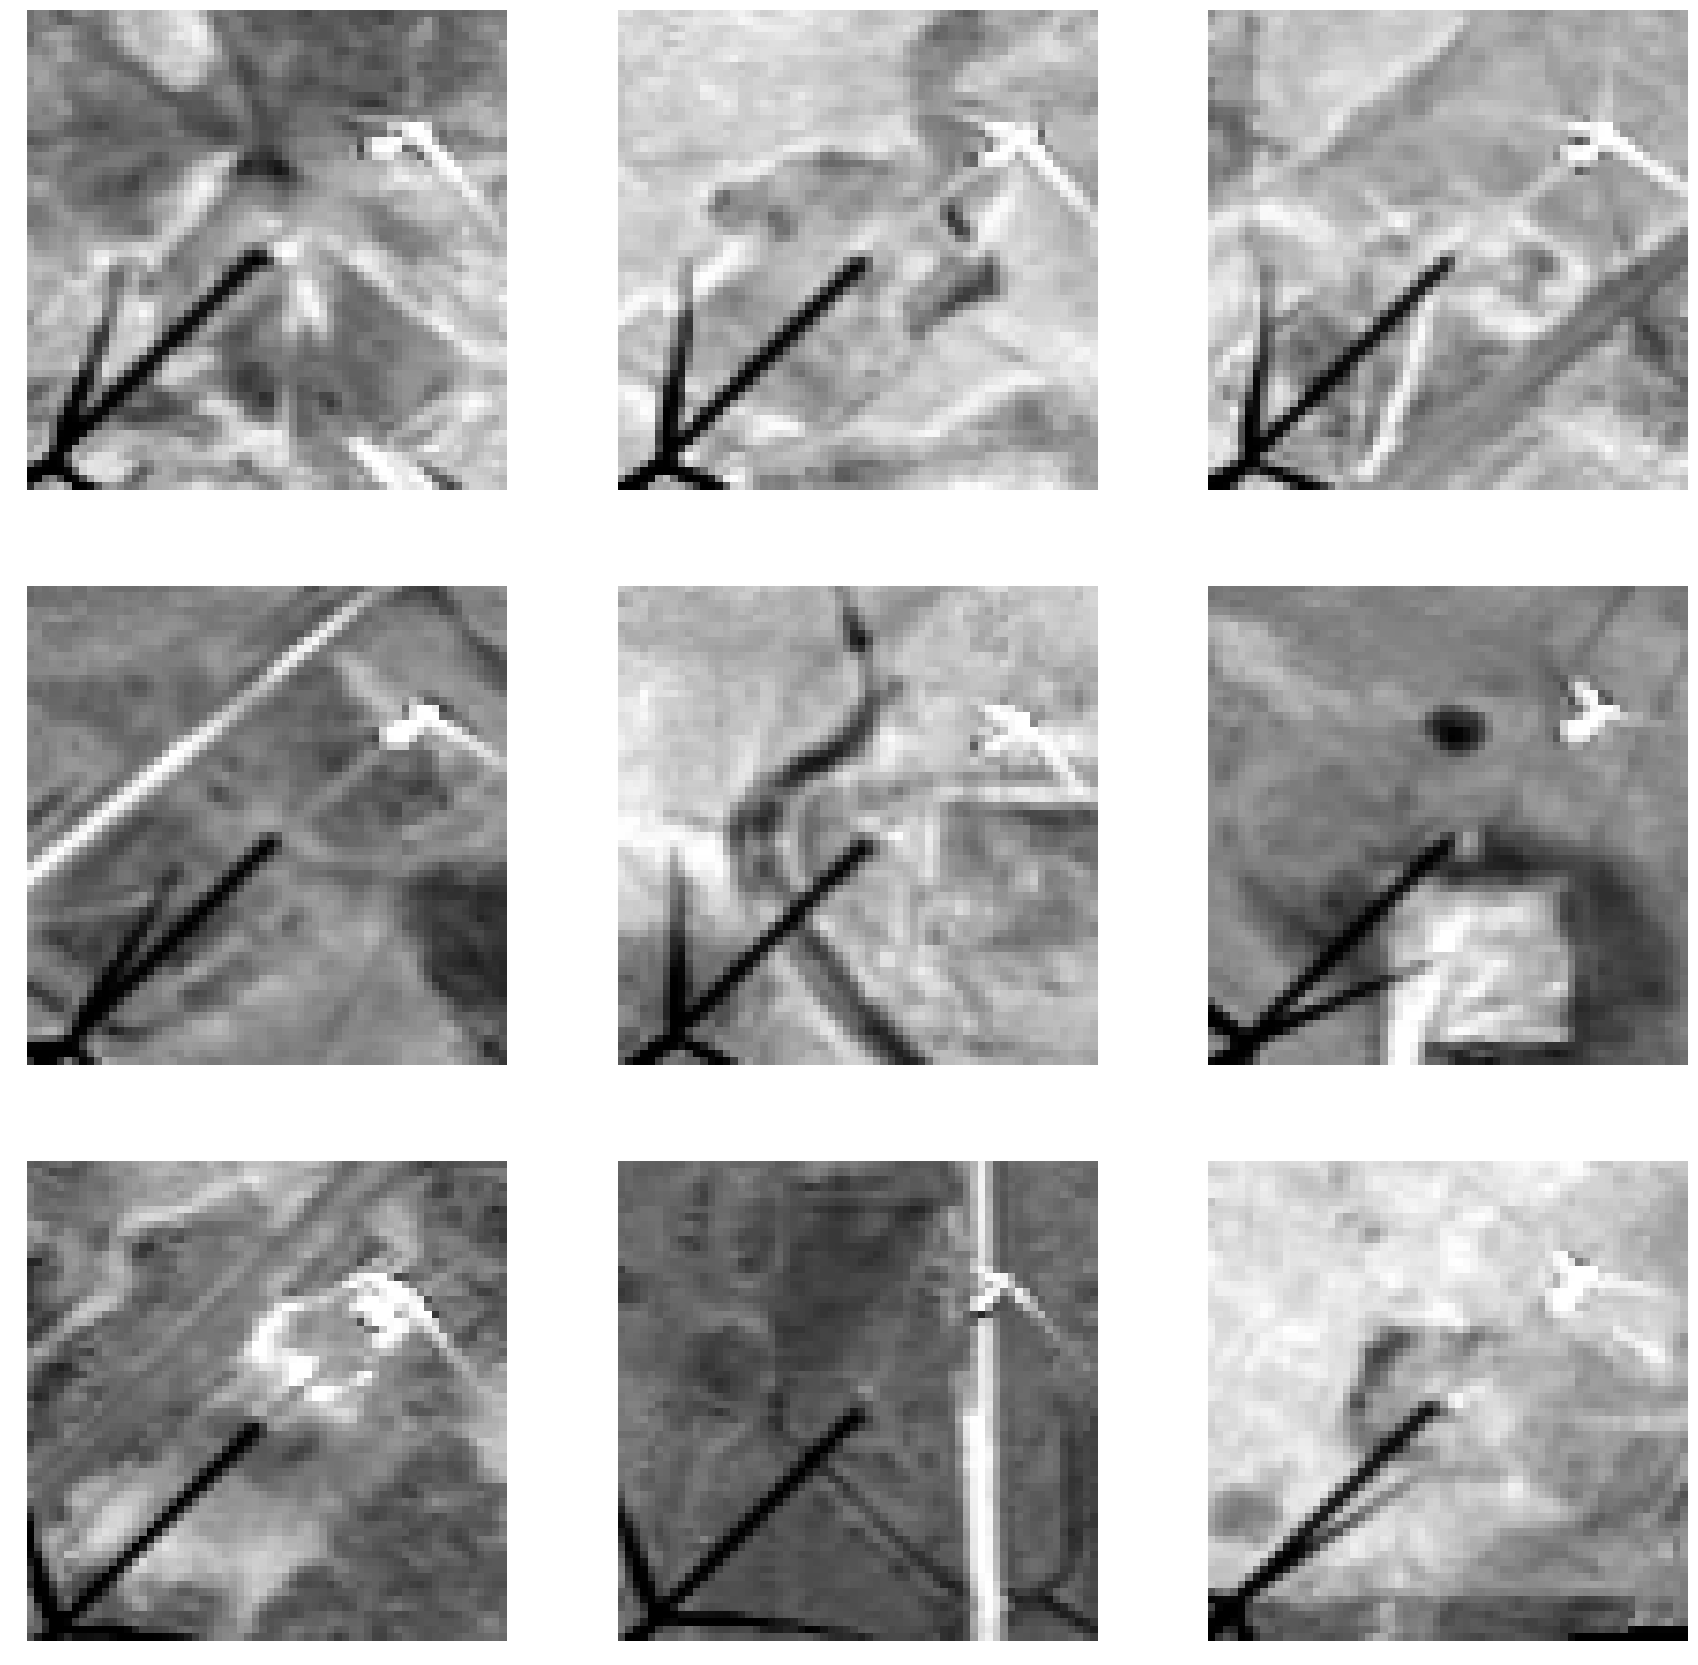

In [109]:
# display sample turbine images

f = plt.figure(figsize=(30,30))
plots_per_side = 3
count = 1
for im in turbine_images:
    ax = f.add_subplot(plots_per_side,plots_per_side,count)
    ax.axis('off')
    ax.imshow(im,cmap="gray")
    #ax.text(0.1,0.8,"{0}".format(cat_id),color='r',fontsize=20,transform=ax.transAxes)
    if count >= plots_per_side ** 2:
        break
    count += 1
plt.show()


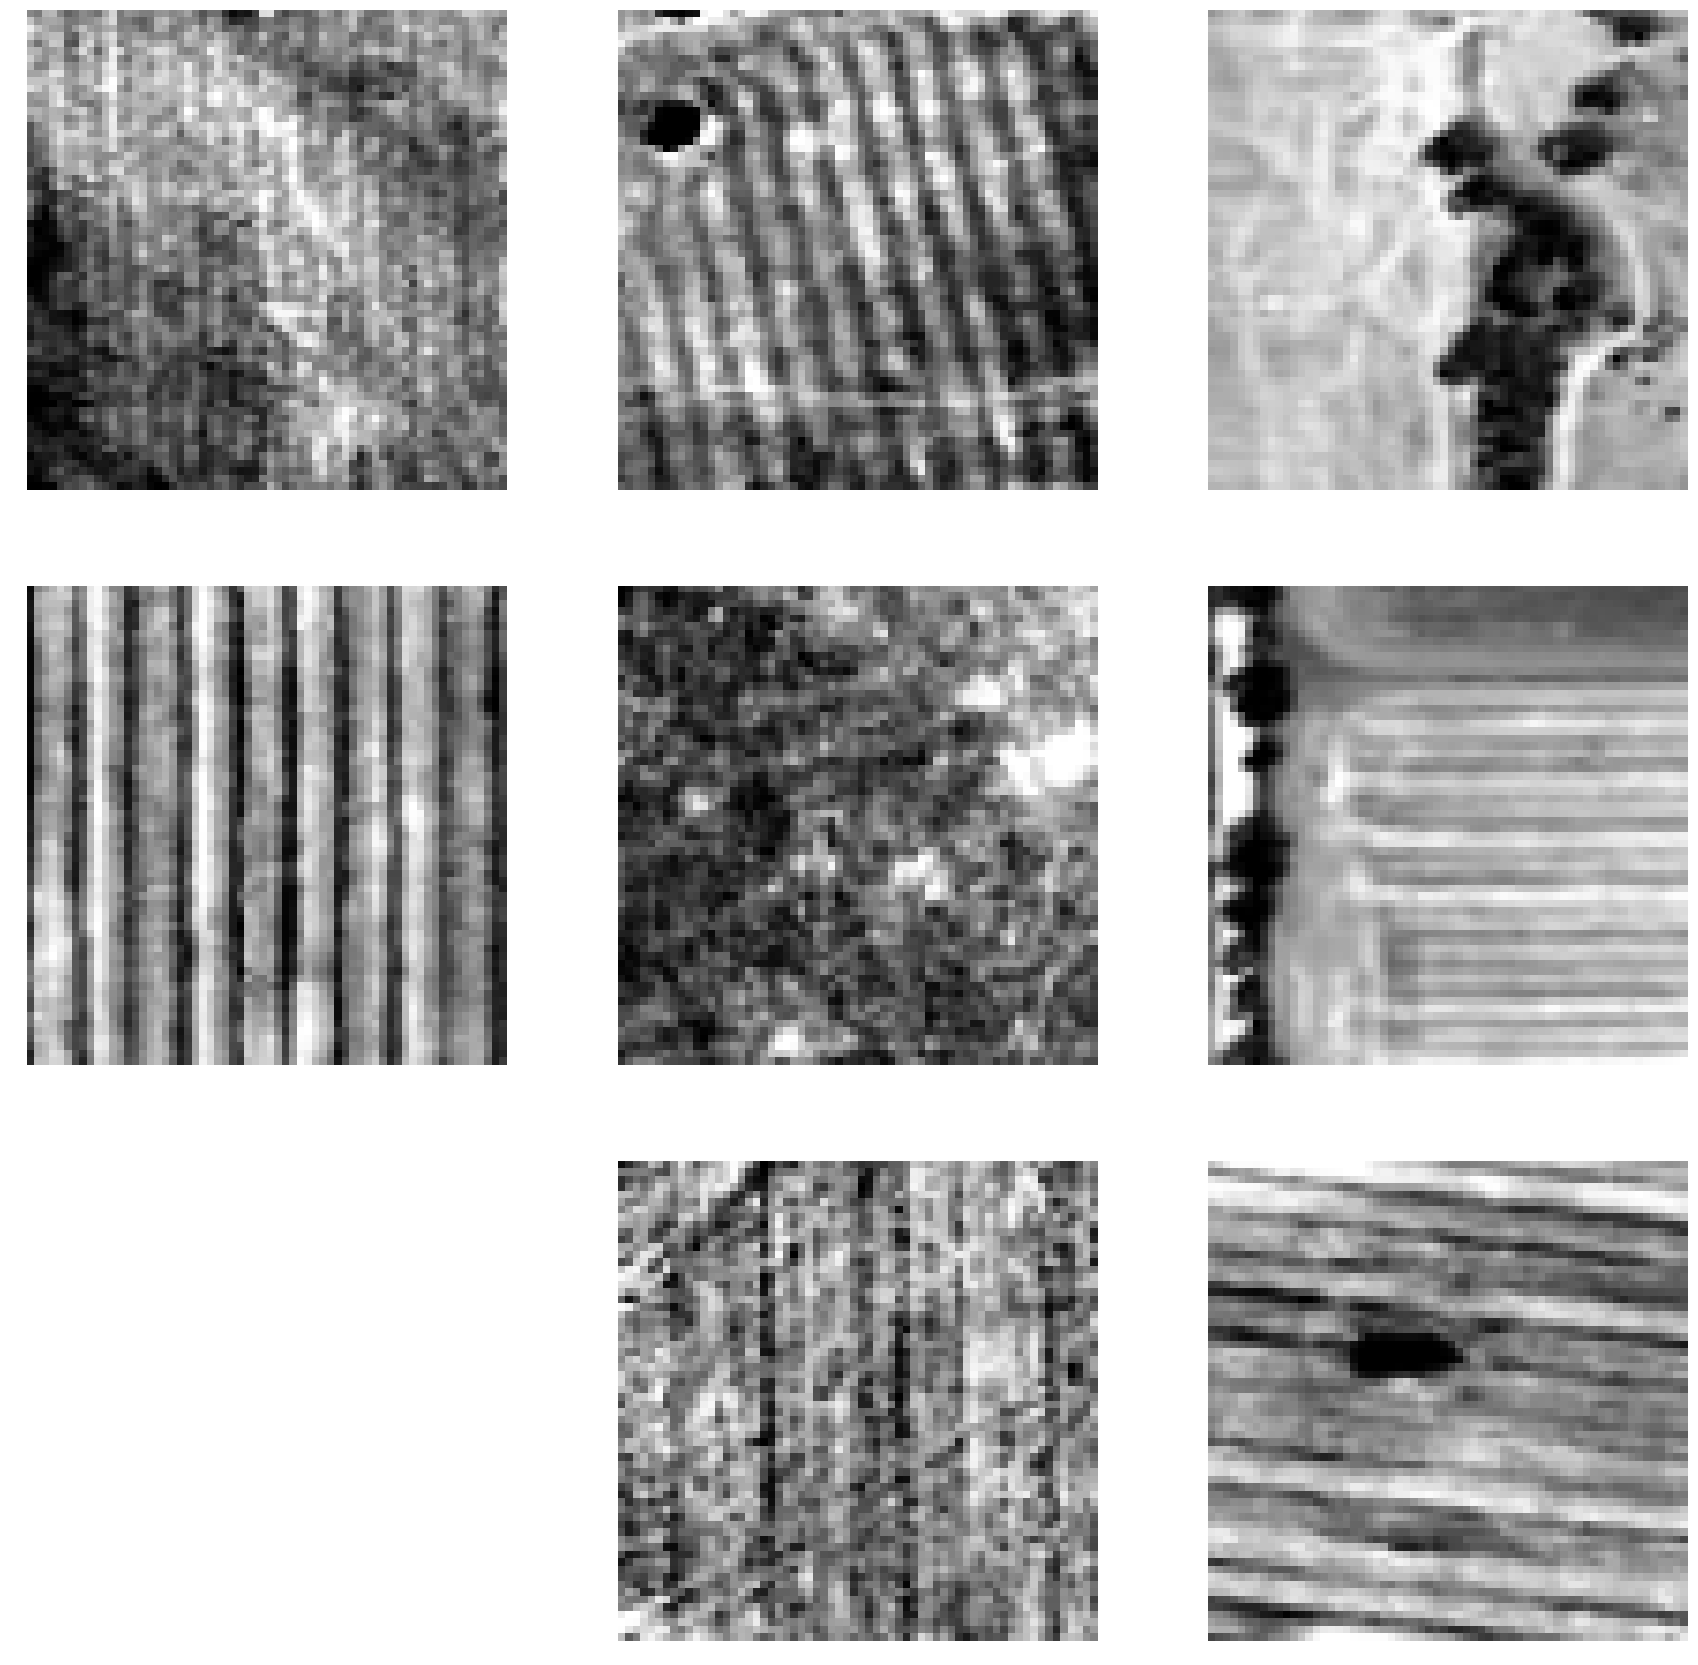

In [108]:
# display sample not-turbine images

f = plt.figure(figsize=(30,30))
plots_per_side = 3
count = 1
for im in not_turbine_images:
    ax = f.add_subplot(plots_per_side,plots_per_side,count)
    ax.axis('off')
    ax.imshow(im,cmap="gray")
    #ax.text(0.1,0.8,"{0}".format(cat_id),color='r',fontsize=20,transform=ax.transAxes)
    if count >= plots_per_side ** 2:
        break
    count += 1
plt.show()

In [110]:
# calculate hog features

turbine_hog_features = []
not_turbine_hog_features = []
for im in turbine_images:
    hog_vec, hog_vis = feature.hog(im,visualise=True)
    turbine_hog_features.append({'hog_vector':hog_vec,'hog_visualization':hog_vis})
for im in not_turbine_images:
    hog_vec, hog_vis = feature.hog(im,visualise=True)
    not_turbine_hog_features.append({'hog_vector':hog_vec,'hog_visualization':hog_vis})


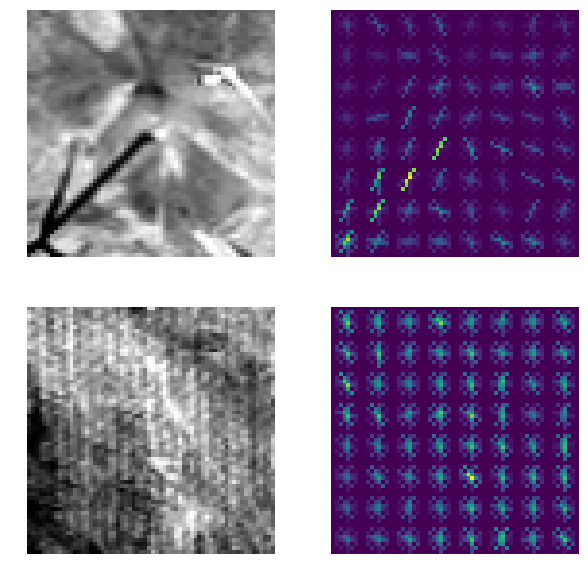

In [111]:
# display sample hog features

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(2,2,1)
ax.axis('off')
ax.imshow(turbine_images[0],cmap='gray')
ax = f.add_subplot(2,2,2)
ax.axis('off')
ax.imshow(feature.hog(turbine_images[0],visualise=True)[1])
ax = f.add_subplot(2,2,3)
ax.axis('off')
ax.imshow(not_turbine_images[0],cmap='gray')
ax = f.add_subplot(2,2,4)
ax.axis('off')
ax.imshow(feature.hog(not_turbine_images[0],visualise=True)[1])
plt.show()


In [114]:
# generate training data from hog features

X_train_all = np.array([feature.hog(im) for im in chain(turbine_images,not_turbine_images)])
y_train_all = np.zeros(X_train_all.shape[0])
y_train_all[:len(turbine_images)] = 1
print(X_train_all.shape)
print(y_train_all.shape)

(2008, 2916)
(2008,)


In [115]:
# problem: some hog features are NaN; need to remove these
NaN_or_Inf_indices = []
for i,hf in enumerate(X_train_all):
    if np.any(np.isnan(hf)) or np.any(np.isinf(hf)):
        NaN_or_Inf_indices.append(i)
        
X_train_clean = np.delete(X_train_all,NaN_or_Inf_indices,axis=0)
y_train_clean = np.delete(y_train_all,NaN_or_Inf_indices)
print(u"Removed {0} training examples because of NaN or Inf entries.".format(len(NaN_or_Inf_indices)))
print(X_train_clean.shape)
print(y_train_clean.shape)

Removed 75 training examples because of NaN or Inf entries.
(1933, 2916)
(1933,)


In [116]:
# train simple classifier

cross_val_score(GaussianNB(), X_train_clean, y_train_clean)

array([0.74263566, 0.76242236, 0.78571429])

In [118]:
# train SVM

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train_clean, y_train_clean)
grid.best_score_

0.7884117951370926